In [1]:
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
import statsmodels.api as sm

# Improving Olist's Estimated Delivery Time (ETA)

👉 `Estimated Time of Arrival (ETA)` is a key component of modern e-commerce services. It allows companies to manage customer expectations by showing a predicted date for customer delivery.

🎯 In this challenge, we will build a predictive model that `estimates the wait time` of an order.

☑️ Olist already has its own predictions under the variable `expected_wait_time`

🚀 Let's challenge ourselves to do better predictions and at the end of this recap, 
we will compare:
* our `estimated_wait_time`
* Olist's `expected_wait_time`
* the real `wait_time` for each order delivered

## Load and check `orders` dataset

👉 `Order().get_training_data()` (include `distance_seller_customer`)

In [3]:
from olist.order import Order
orders = Order().get_training_data(with_distance_seller_customer=True)

In [4]:
orders.head(3)

,order_id,wait_time,expected_wait_time,delay_vs_expected,order_status,dim_is_five_star,dim_is_one_star,review_score,number_of_products,number_of_sellers,price,freight_value,distance_seller_customer
0,e481f51cbdc54678b7cc49136f2d6af7,8.436574,15.544063,0.0,delivered,0,0,4,1,1,29.99,8.72,18.063837
1,53cdb2fc8bc7dce0b6741e2150273451,13.782037,19.137766,0.0,delivered,0,0,4,1,1,118.70,22.76,856.292580
2,47770eb9100c2d0c44946d9cf07ec65d,9.394213,26.639711,0.0,delivered,1,0,5,1,1,159.90,19.22,514.130333


In [5]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 95872 entries, 0 to 95879
Data columns (total 13 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   order_id                  95872 non-null  object 
 1   wait_time                 95872 non-null  float64
 2   expected_wait_time        95872 non-null  float64
 3   delay_vs_expected         95872 non-null  float64
 4   order_status              95872 non-null  object 
 5   dim_is_five_star          95872 non-null  int64  
 6   dim_is_one_star           95872 non-null  int64  
 7   review_score              95872 non-null  int64  
 8   number_of_products        95872 non-null  int64  
 9   number_of_sellers         95872 non-null  int64  
 10  price                     95872 non-null  float64
 11  freight_value             95872 non-null  float64
 12  distance_seller_customer  95872 non-null  float64
dtypes: float64(6), int64(5), object(2)
memory usage: 10.2+ MB


## Baseline Model - Olist’s current ETA model

🐣  What's the baseline we want to optimize ❓

👉 The delta between Olist' `expected_wait_time` and the real `wait_time`

📈 Plot their respective histograms

<AxesSubplot:xlabel='expected_wait_time', ylabel='Count'>

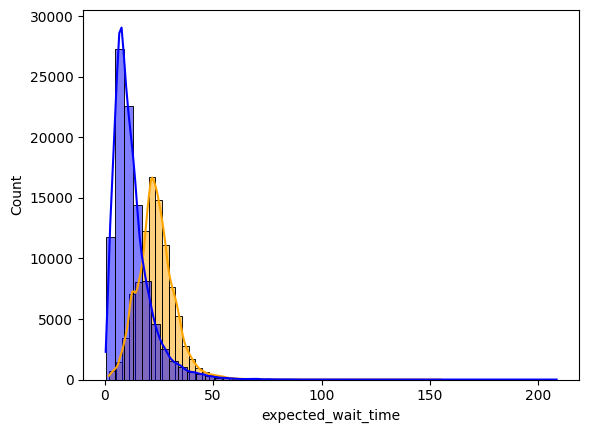

In [6]:
sns.histplot(orders.expected_wait_time, kde=True, bins=50, color='orange')
sns.histplot(orders.wait_time, kde=True, bins=50, color='blue')

👉 What is the median wait time ? the median expected wait time ? 

In [7]:
median_wait_time = orders.wait_time.median()
median_expected_wait_time = orders.expected_wait_time.median()
print(f"""median wait time: {median_wait_time:.1f} days
median expected wait time: {median_expected_wait_time:.1f} days
""")

median wait time: 10.2 days
median expected wait time: 23.2 days



👉 Compute the baseline RMSE 

ℹ️ The errors considered here are the misapproximations from Olist in terms of waiting time.

In [8]:
# RMSE: Root Mean Squared Error
baseline_rmse = np.sqrt(np.mean((orders.expected_wait_time - orders.wait_time)**2))
print(f"Baseline RMSE: {baseline_rmse:.1f} days")

Baseline RMSE: 15.1 days


## OLS multivariate model

👉 We will create an OLS model using the `statsmodel.api.OLS` method this time.

(instead of `statsmodel.formula.api.ols`) 

### Prepare the dataset with the  features X and the target Y

In [9]:
orders.columns

Index(['order_id', 'wait_time', 'expected_wait_time', 'delay_vs_expected',
       'order_status', 'dim_is_five_star', 'dim_is_one_star', 'review_score',
       'number_of_products', 'number_of_sellers', 'price', 'freight_value',
       'distance_seller_customer'],
      dtype='object')

In [10]:
features = ['number_of_products', 'number_of_sellers', 'price', 'freight_value',
            'distance_seller_customer']

y = orders.wait_time.copy()
X = orders[features].copy()
X.head()

,number_of_products,number_of_sellers,price,freight_value,distance_seller_customer
0,1,1,29.99,8.72,18.063837
1,1,1,118.70,22.76,856.292580
2,1,1,159.90,19.22,514.130333
3,1,1,45.00,27.20,1822.800366
4,1,1,19.90,8.72,30.174037


⚖️ Standardize (`z-score`) each feature of X to compare regression coefficients that will result from the OLS:

In [11]:
# We store mu and sigma to be able to re-use them later in our predictions
mu = X.mean()
sigma = X.std()

standardized_X = (X - mu) / sigma
standardized_X

,number_of_products,number_of_sellers,price,freight_value,distance_seller_customer
0,-0.264595,-0.112544,-0.513802,-0.652038,-0.979475
1,-0.264595,-0.112544,-0.086640,0.000467,0.429743
2,-0.264595,-0.112544,0.111748,-0.164053,-0.145495
3,-0.264595,-0.112544,-0.441525,0.206815,2.054621
4,-0.264595,-0.112544,-0.562388,-0.652038,-0.959115
...,...,...,...,...,...
95875,-0.264595,-0.112544,-0.311513,-0.449408,-0.893033
95876,-0.264595,-0.112544,0.183977,-0.123156,-0.212797
95877,-0.264595,-0.112544,0.333684,1.964490,0.617630
95878,1.601605,-0.112544,1.075186,2.715522,-0.387558


In [12]:
# def z_score(series):
#     mu = series.mean()
#     sigma = series.std()
#     return (series - mu) / sigma

# # df.apply, series.apply => applies a function to each series (takes a series or df as an argument)
# # series.map => applies a function to each value of a series (takes a value as an argument)
# # df.applymap => apply a function to each value of a dataframe

# standardized_X = X.apply(z_score)
# standardized_X

In [13]:
' + '.join(features)

'number_of_products + number_of_sellers + price + freight_value + distance_seller_customer'

In [14]:
# Check how different is it from the "formula" in statsmodel
# smf.OLS(formula='target ~ feature_1 + feature_2')
import patsy
pd.DataFrame(patsy.dmatrix(' + '.join(features), standardized_X))

,0,1,2,3,4,5
0,1.0,-0.264595,-0.112544,-0.513802,-0.652038,-0.979475
1,1.0,-0.264595,-0.112544,-0.086640,0.000467,0.429743
2,1.0,-0.264595,-0.112544,0.111748,-0.164053,-0.145495
3,1.0,-0.264595,-0.112544,-0.441525,0.206815,2.054621
4,1.0,-0.264595,-0.112544,-0.562388,-0.652038,-0.959115
...,...,...,...,...,...,...
95867,1.0,-0.264595,-0.112544,-0.311513,-0.449408,-0.893033
95868,1.0,-0.264595,-0.112544,0.183977,-0.123156,-0.212797
95869,1.0,-0.264595,-0.112544,0.333684,1.964490,0.617630
95870,1.0,1.601605,-0.112544,1.075186,2.715522,-0.387558


⚠️ With this `statsmodel.api.OLS`, we always need to add a constant "intercept" to the features dataset:

In [15]:
standardized_X['intercept'] = 1
standardized_X

,number_of_products,number_of_sellers,price,freight_value,distance_seller_customer,intercept
0,-0.264595,-0.112544,-0.513802,-0.652038,-0.979475,1
1,-0.264595,-0.112544,-0.086640,0.000467,0.429743,1
2,-0.264595,-0.112544,0.111748,-0.164053,-0.145495,1
3,-0.264595,-0.112544,-0.441525,0.206815,2.054621,1
4,-0.264595,-0.112544,-0.562388,-0.652038,-0.959115,1
...,...,...,...,...,...,...
95875,-0.264595,-0.112544,-0.311513,-0.449408,-0.893033,1
95876,-0.264595,-0.112544,0.183977,-0.123156,-0.212797,1
95877,-0.264595,-0.112544,0.333684,1.964490,0.617630,1
95878,1.601605,-0.112544,1.075186,2.715522,-0.387558,1


### Run OLS with `statsmodels` and print `summary`

In [16]:
# y, standardized_X
model = sm.OLS(y, standardized_X)
model = model.fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              wait_time   R-squared:                       0.161
Model:                            OLS   Adj. R-squared:                  0.161
Method:                 Least Squares   F-statistic:                     3676.
Date:                Wed, 23 Oct 2024   Prob (F-statistic):               0.00
Time:                        18:27:18   Log-Likelihood:            -3.4301e+05
No. Observations:               95872   AIC:                         6.860e+05
Df Residuals:                   95866   BIC:                         6.861e+05
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
============================================================================================
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
number_of_products          -0.3104      0.033     -9.481      0.000      -0.375      -0.246
number_of_sellers           -0.3557      0.029    -12.174      0.000      -0.413      -0.298
price                        0.0474      0.031      1.542      0.123      -0.013       0.108
freight_value                0.6392      0.036     17.717      0.000       0.568       0.710
distance_seller_customer     3.5219      0.030    117.298      0.000       3.463       3.581
intercept                   12.5134      0.028    447.350      0.000      12.459      12.568
==============================================================================
Omnibus:                    91515.661   Durbin-Watson:                   1.989
Prob(Omnibus):                  0.000   Jarque-Bera (JB):         10123039.937
Skew:                           4.333   Prob(JB):                         0.00
Kurtosis:                      52.589   Cond. No.                         2.18
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## Check the performance of your OLS model

### Goodness of fit

👉 Who has the best predictions, you or Olist ? 

- Compute your predictions and store them in `y_pred`

- You can store :
    - Olist's predictions in a `y_expected_olist` variable
    - the real waiting times in a `y_true` variable



In [17]:
new_sample = (pd.DataFrame(data=[[6, 3, 246, 23, 2000]], columns=features) - mu) / sigma
new_sample['intercept'] = 1
new_sample

,number_of_products,number_of_sellers,price,freight_value,distance_seller_customer,intercept
0,9.066407,16.064153,0.526343,0.011621,2.352526,1


In [18]:
model.predict([new_sample])

array([[12.30275556]])

📈 Plot `y_pred`, `y_expected_olist` and `y_true` on the same graph.

In [19]:
y_pred = model.predict(standardized_X)
y_expected_olist = orders.expected_wait_time
y_true = orders.wait_time

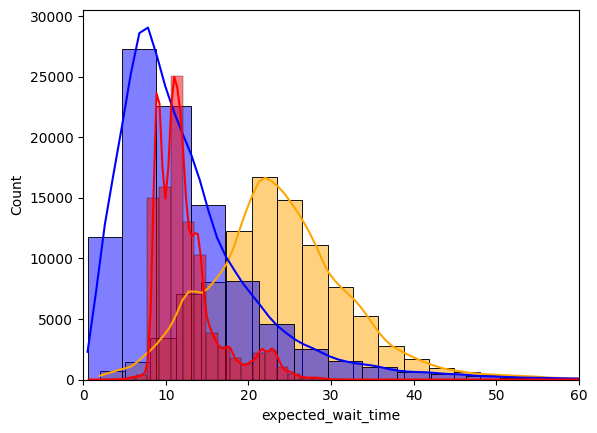

In [20]:
sns.histplot(y_expected_olist, kde=True, bins=50, color='orange')
sns.histplot(y_true, kde=True, bins=50, color='blue')
sns.histplot(y_pred, kde=True, bins=50, color='red')
plt.xlim(0,60);

👉 Compute the RMSE where the errors are now *your* errors !

In [21]:
# RMSE: Root Mean Squared Error
our_rmse = np.sqrt(np.mean((y_pred - y_true)**2))
print(f"Our RMSE: {our_rmse:.1f} days")

Our RMSE: 8.7 days


Just as a reminder, Olist's RMSE was equal to : 👇

In [22]:
baseline_rmse

15.110701386210625

😏 Did we really beat Olist's Data Scientists ? We cannot really say that!

- In many e-commerce and delivery services, the ETA is often overestimated...
- When customers receive their orders earlier than expected, they are more likely to be satisfied !

### Partial correlations

👉 Visualize partial correlations with `sm.graphics.plot_partregress_grid`

In [23]:
# YOUR CODE HERE

**How do we read these graphs ?**

👉 Let's focus - for instance - on the graph in the bottom left corner:

<u>Partial regression of `wait_time` against `distance`</u>

- Each point is an order in our dataset


- `y-axis`: residuals of the `wait_time`, using all features except `distance`

    - These residuals contain the remaining information about `wait_time` that couldn't be explained without `distance`


- `x-axis`: residuals of predicting `distance` by using all other features (price, freight_value, etc...)
    - These residuals contain the new information that `distance` brings to the table, which is not already explained by the other features in the model.



### Inferential conditions

⚠️ Check you residuals. Are they normally distributed?

In [24]:
# YOUR CODE HERE

🎁 A more precise way to visualize whether a distribution is Gaussian or not is the <a href="https://www.statsmodels.org/stable/generated/statsmodels.graphics.gofplots.qqplot.html">**`QQplot`**</a>. 

📈 Plot the QQplot of your residual below

💡 Make sure to understand the relation between the QQ plot and the density previsouly drawn..

📚 <a href="https://stats.stackexchange.com/questions/101274/how-to-interpret-a-qq-plot">Stats.StackExchange.com - Interpreting QQplots</a>

- `x-axis` : theoretical quantiles of a Gaussian distribution
- `y-axis`: quantiles of the sorted variable

💡 If the <span style="color:blue">blue</span> points are aligned on the <span style="color:red">red line</span> which is the identity function, the variable has a Gaussian distribution !

In [25]:
sm.qqplot(residuals_lewagon, line='s');

NameError: name 'residuals_lewagon' is not defined

#### Some QQplot examples:

Run the cells below to understand how QQ plots are graphed:

In [ ]:
from scipy import stats
stats.norm.rvs(0,1)

In [ ]:
# lets check QQ plots with our own distributions
from scipy import stats

norm_1 = [stats.norm.rvs(0,1) for x in range(1000)]
norm_2 = [stats.norm.rvs(5,1) for x in range(1000)]

sns.kdeplot(norm_1)
sns.kdeplot(norm_2)
plt.xlim(right=10)

In [ ]:
sm.qqplot(np.asarray(norm_1), line='s');

In [ ]:
bimodal = norm_1 + norm_2
sns.kdeplot(bimodal)
plt.xlim(right=10)

In [ ]:
sm.qqplot(np.asarray(bimodal), line='s');

<img src="https://wagon-public-datasets.s3.amazonaws.com/04-Decision-Science/03-Linear-Regression/qq_plot_interpretation.png" width=400>

#### Check residuals vs. fitted to see if we can detect any non-random pattern

In [ ]:
sns.scatterplot(x = y_pred, y = residuals_lewagon, alpha=0.01)
plt.xlim(xmin=0, xmax=50)

## More Features? (Optional)

Here we can add additional features from the product details (size, category etc..)

### Add product details associated with each order (sum of product sizes, sum of weights etc...)

In [ ]:
from olist.data import Olist
data = Olist().get_data()
products = data['products']
order_items = data['order_items']

In [ ]:
order_items_products = (
    order_items.groupby(["order_id", "product_id"], as_index=False)
    .agg({"order_item_id": "count"})
    .rename(columns={"order_item_id": "order_item_count"})
    .merge(products.drop(["product_category_name"], axis=1), on="product_id")
)
order_items_products

In [ ]:
# Since we want the sum of product weights per order from our new DataFrame, we need to multiply weight by product count
order_items_products['product_weight_g'] = order_items_products['product_weight_g'] *  order_items_products['order_item_count']

order_items_features = order_items_products.groupby("order_id", as_index=False).agg(
    {
        "product_weight_g": "sum",
        "product_length_cm": "max",
        "product_height_cm": "max",
        "product_width_cm": "max",
    }).rename(columns={
        "product_weight_g": "product_weight_g_sum",
        "product_length_cm": "product_length_cm_max",
        "product_height_cm": "product_height_cm_max",
        "product_width_cm": "product_width_cm_max",
    })
order_items_features

In [ ]:
orders_with_details = orders.merge(order_items_features, on="order_id", how="left").dropna()

In [ ]:
X2 = orders_with_details[[
        "number_of_items",
        "number_of_sellers",
        "price",
        "freight_value",
        "distance_seller_customer",
        "product_weight_g_sum",
        "product_length_cm_max",
        "product_height_cm_max",
        "product_width_cm_max"]].copy()
y2 = orders_with_details["wait_time"].copy()

In [ ]:
# standardize (z-normalize) each features of X to compare coefficients
for f in X2.columns:
    mu = X2[f].mean()
    sigma = X2[f].std()
    X2[f] = X2[f].map(lambda x: (x - mu) / sigma)

In [ ]:
X2['constant'] = 1

In [ ]:
model2 = sm.OLS(y2, X2).fit()

In [ ]:
model2.summary()